In [66]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [105]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [106]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 0.5] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 500
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  3.416729 seconds (7.95 M allocations: 10.153 GiB, 5.95% gc time, 49.05% compilation time)
Estimation of index coefs: 
̂α => [0.39388920570059066; 0.9191579263829247]
̂γ => [0.5, 0.5]
Estimation of linear coefs: 
̂θ => [2.1071788611002886 -0.9029949957936705]
̂β => [2.2479744324463797, -1.013522474989979]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

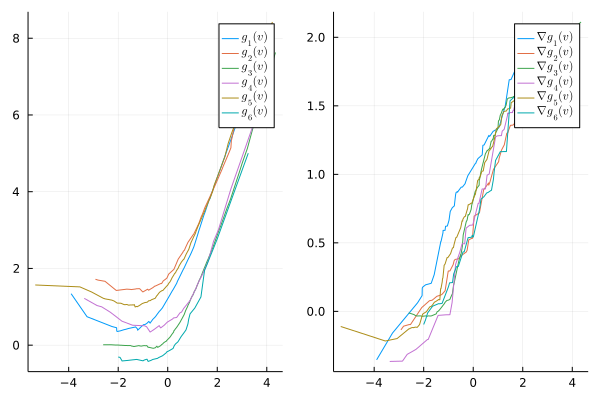

In [98]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), 0.5, -0.4) # g: g(v), dg: g'(v)
p1 = plot()
p2 = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
plot(p1, p2, layout = (1,2))



# Monte Carlo Simulation

In [70]:
Threads.nthreads()

2

In [111]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [112]:
α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 0.5] # single index for z
β = [1.0, -0.5] # linear for z
τ = 0.25
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 300
fx = 2
dist = 1 # Cauchy
rep = 200 # MC rept. times

200

In [119]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)
mean(Gamma, dims = 1)

0.0%┣                                             ┫ 0/200 [00:00<00:-10, -0s/it]
0.5%┣▏                                         ┫ 1/200 [00:01<Inf:Inf, InfGs/it]
1.0%┣▌                                              ┫ 2/200 [00:02<07:10, 2s/it]


LoadError: InterruptException:

In [118]:
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.290571  0.31546

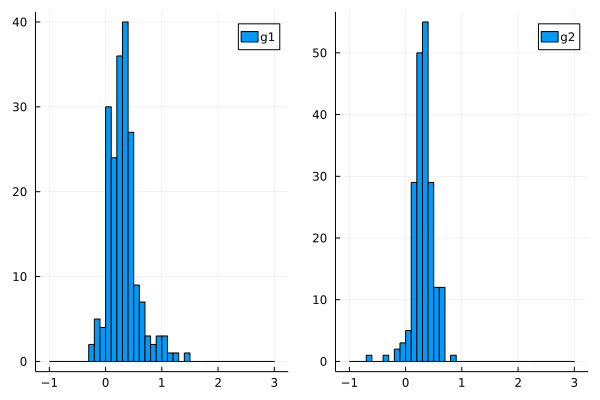

In [114]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [115]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 1.2019  -0.634546

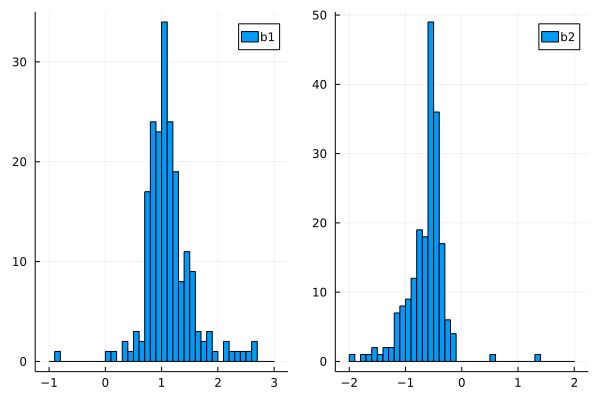

In [126]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [120]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.453214  0.874432

In [124]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.94041  -0.964825

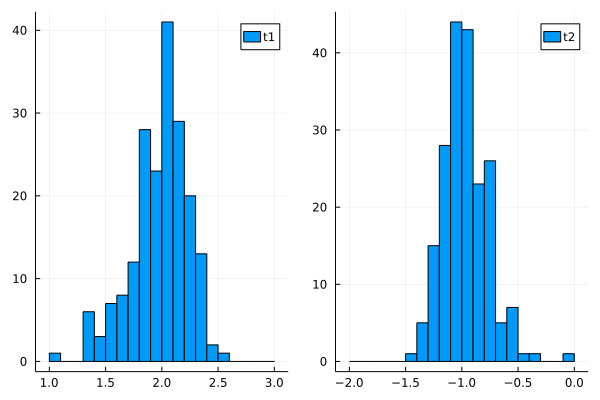

In [123]:
p1 = histogram(Theta[:,1], bins = 1:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

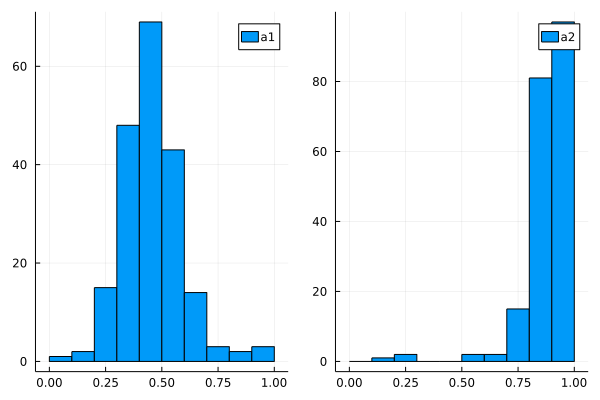

In [125]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))